In [4]:
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.1/671.1 kB 8.3 MB/s eta 0:00:0000:0100:01


In [5]:

import numpy as np
import pandas as pd
import os

import pickle
import torch
from aiirw import AI_IRW
import matplotlib.pyplot as plt
from _ood_classifier import OODDetector

import seaborn as sns
sns.set_style('white')

In [6]:
with open('embeddings_imbd_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('logits_imdb_train.pkl', 'rb') as f:
    logit_train = pickle.load(f)

with open('attns_imdb_train.pkl', 'rb') as f:
    attn_train = pickle.load(f)

In [7]:
embd_ood = []
for fn in [el for el in os.listdir() if el.startswith('embeddings_ood_')]:
    with open(fn, 'rb') as f:
        embd_ = pickle.load(f)
    embd_ood += embd_

logit_ood = []
for fn in [el for el in os.listdir() if el.startswith('logits_ood_')]:
    with open(fn, 'rb') as f:
        logit_ = pickle.load(f)
    logit_ood += logit_

attn_ood = []
for fn in [el for el in os.listdir() if el.startswith('attns_ood_')]:
    with open(fn, 'rb') as f:
        attn_ = pickle.load(f)
    attn_ood += attn_



In [8]:
with open('embeddings_imdb_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

with open('logits_imdb_test.pkl', 'rb') as f:
    logit_test = pickle.load(f)

with open('attns_imdb_test.pkl', 'rb') as f:
    attn_test = pickle.load(f)

In [9]:
logit_train = torch.cat(logit_train).numpy()
attn_train = torch.cat(attn_train).numpy()
embd_train = torch.cat(embd_train).numpy()

embd_train_distrib  = {l: embd_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}
attn_train_distrib  = {l: attn_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}

In [10]:
logit_test = torch.cat(logit_test).numpy()
embd_test = torch.cat(embd_test).numpy()
attn_test = torch.cat(attn_test).numpy()


embd_test_distrib  = {l: embd_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}
attn_test_distrib  = {l: attn_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}



In [11]:
logit_ood = torch.cat(logit_ood).numpy()
embd_ood = torch.cat(embd_ood).numpy()
attn_ood = torch.cat(attn_ood).numpy()

embd_ood_distrib  = {l: embd_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}
attn_ood_distrib  = {l: attn_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}



In [72]:
X_0_embd =  np.concatenate((embd_ood_distrib[0], embd_test_distrib[0]))
X_0_attn =  np.concatenate((attn_ood_distrib[0], attn_test_distrib[0]))
y_0 =   np.concatenate((np.ones((embd_ood_distrib[0].shape[0])), np.zeros((embd_test_distrib[0].shape[0]))))

X_1_embd =  np.concatenate((embd_ood_distrib[1], embd_test_distrib[1]))
X_1_attn =  np.concatenate((attn_ood_distrib[1], attn_test_distrib[1]))
y_1 =   np.concatenate((np.ones((embd_ood_distrib[1].shape[0])), np.zeros((embd_test_distrib[1].shape[0]))))

X_embd = np.concatenate((logit_ood, logit_test))
X_attn = np.concatenate((attn_ood, attn_test))
y_ = np.concatenate((np.ones(logit_ood.shape[0]), np.zeros(logit_test.shape[0])))

In [40]:
#import random search from sklearn
from sklearn.model_selection import RandomizedSearchCV
#import shuffle from sklearn
from sklearn.utils import shuffle

X_0, y_0 = shuffle(X_0, y_0)
X_1, y_1 = shuffle(X_1, y_1)
X_, y_ = shuffle(X_, y_)

# Create the parameter grid based on the results of random search, tau follows a gaussian centered in 50 with std 10
param_grid = {
    'tau': np.random.uniform(-150, 0, 100), 
    'similarity': ['mahalanobis'],
    'base_distribution' : [train_distrib[0]]
}

# Create a based model
clf = OODDetector(similarity='mahalanobis', tau=50, base_distribution=train_distrib[0])

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid,
                            cv = 5, n_jobs = -1, verbose = 0, scoring='balanced_accuracy')


In [41]:
grid_search.fit(X_0, y_0)
print(grid_search.best_params_)

{'tau': -53.24070283187717, 'similarity': 'mahalanobis', 'base_distribution': array([[ 0.1655158 ,  0.19259338, -0.05701194, ..., -0.04087529,
         0.06450007,  0.27201617],
       [ 0.26176506,  0.13326405,  0.04254614, ..., -0.02392149,
         0.06750306,  0.20914446],
       [ 0.16050506, -0.07738341,  0.21776502, ..., -0.1432903 ,
        -0.04918719, -0.1345499 ],
       ...,
       [-0.07087212, -0.27570873,  0.08874413, ..., -0.14185995,
        -0.05530067, -0.18070912],
       [-0.13870718, -0.08804137, -0.18017988, ..., -0.1654126 ,
        -0.06333739, -0.11101169],
       [ 0.00867541, -0.23554574,  0.14202845, ..., -0.29557773,
        -0.16673136, -0.346024  ]], dtype=float32)}


In [17]:
grid_search.best_score_

0.9770796974985456

In [57]:
 clf = OODDetector(similarity='mahalanobis', tau=1, base_distribution=train_distrib[1]).fit()

In [21]:
from sklearn.metrics import roc_auc_score

In [58]:
roc_auc_score(y_1, np.abs(clf.predict_proba(X_1)))

0.998754787634665

In [25]:
clf.predict_proba(X_0)

array([-43.64105068, -16.59505697, -19.85955733, ..., -41.28905296,
       -52.61064528, -20.90586548])

(array([  1.,   3.,   5.,  26.,  35.,  85., 226., 387., 309.,  70.]),
 array([-145.64682839, -136.75579608, -127.86476376, -118.97373145,
        -110.08269913, -101.19166682,  -92.3006345 ,  -83.40960219,
         -74.51856987,  -65.62753756,  -56.73650524]),
 <BarContainer object of 10 artists>)

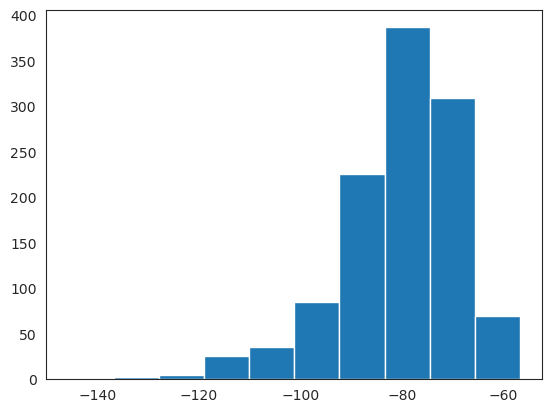

In [13]:
plt.hist(clf._compute_sim(ood_distrib[0]))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        8.400e+01, 1.228e+03, 6.778e+03, 9.096e+03]),
 array([-160.78633755, -145.94475275, -131.10316796, -116.26158316,
        -101.41999837,  -86.57841357,  -71.73682877,  -56.89524398,
         -42.05365918,  -27.21207439,  -12.37048959]),
 <BarContainer object of 10 artists>)

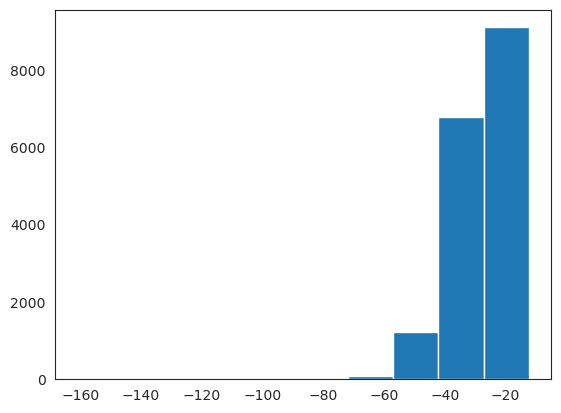

In [14]:
plt.hist(clf._compute_sim(test_distrib[0]))

In [73]:
clf = OODDetector(tau=1, similarity='wass2unif')

AssertionError: Similarity is not available